In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

In [2]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
df = transactions.merge(customers, on="CustomerID", how="left")

In [3]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['SignupDate'] = pd.to_datetime(df['SignupDate'])
df['Recency'] = (df['TransactionDate'].max() - df['TransactionDate']).dt.days
df['Tenure'] = (df['TransactionDate'].max() - df['SignupDate']).dt.days
df['Frequency'] = df.groupby('CustomerID')['TransactionID'].transform('count')

In [4]:
df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate,Recency,Tenure,Frequency
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,124,756,4
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,214,115,4
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,247,268,6
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,276,261,7
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,281,1019,4


In [5]:
customer_features = df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Recency': 'min',
    'Tenure': 'max',
    'Frequency': 'max',
    'Region': 'first'
}).reset_index()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   object        
 1   CustomerID       1000 non-null   object        
 2   ProductID        1000 non-null   object        
 3   TransactionDate  1000 non-null   datetime64[ns]
 4   Quantity         1000 non-null   int64         
 5   TotalValue       1000 non-null   float64       
 6   Price            1000 non-null   float64       
 7   CustomerName     1000 non-null   object        
 8   Region           1000 non-null   object        
 9   SignupDate       1000 non-null   datetime64[ns]
 10  Recency          1000 non-null   int64         
 11  Tenure           1000 non-null   int64         
 12  Frequency        1000 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(4), object(5)
memory usage: 109.4+ KB


In [7]:
label_encoder = LabelEncoder()
customer_features['Region_Encoded'] = label_encoder.fit_transform(customer_features['Region'])
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(customer_features[['TotalValue', 'Quantity', 'Recency', 'Tenure', 'Frequency']])
X = np.hstack((scaled_features, customer_features[['Region_Encoded']].values))

In [8]:
df.drop(
    columns=['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate', 'SignupDate', 'CustomerName'],
    inplace=True
)

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Region_Encoded'] = label_encoder.fit_transform(df['Region'])
df.drop(columns=['Region'], inplace=True)

In [10]:
df.head()

,Quantity,TotalValue,Price,Recency,Tenure,Frequency,Region_Encoded
0,1,300.68,300.68,124,756,4,1
1,1,300.68,300.68,214,115,4,0
2,1,300.68,300.68,247,268,6,1
3,2,601.36,300.68,276,261,7,3
4,3,902.04,300.68,281,1019,4,1


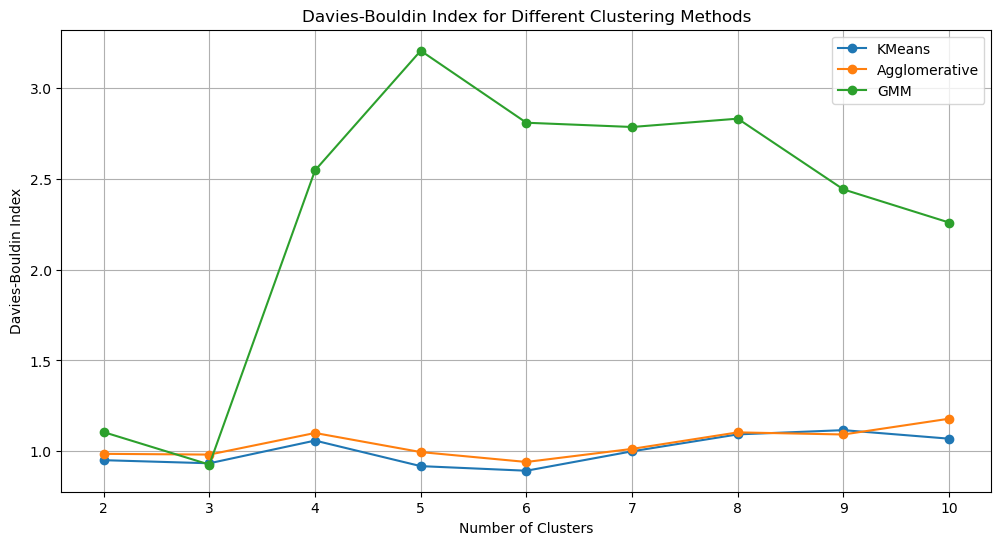

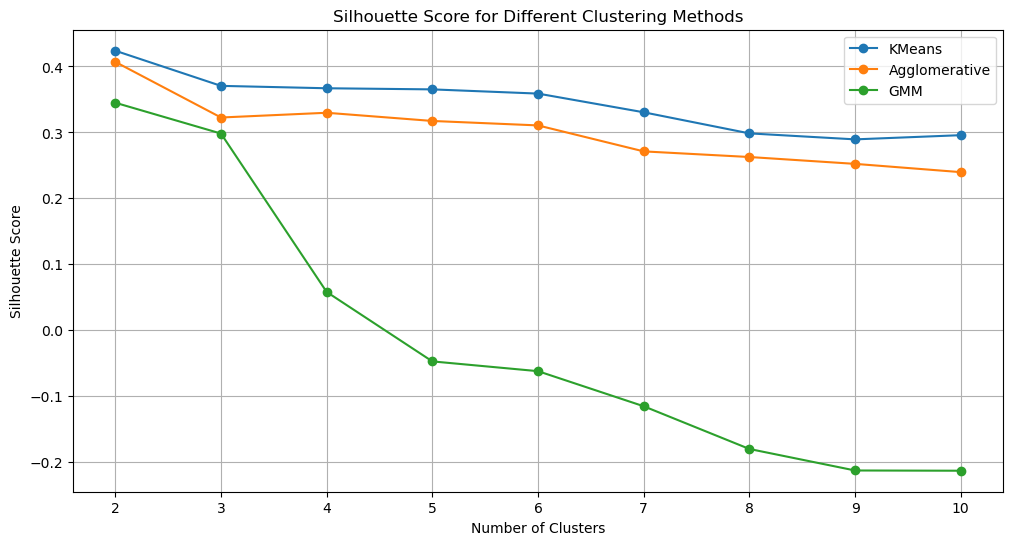

In [11]:
X = df.values
cluster_range = range(2, 11)
db_scores = {'KMeans': [], 'Agglomerative': [], 'GMM': []}
sil_scores = {'KMeans': [], 'Agglomerative': [], 'GMM': []}

for n_clusters in cluster_range:
    # K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)
    db_scores['KMeans'].append(davies_bouldin_score(X, kmeans_labels))
    sil_scores['KMeans'].append(silhouette_score(X, kmeans_labels))
    
    # Agglomerative Clustering
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agg.fit_predict(X)
    db_scores['Agglomerative'].append(davies_bouldin_score(X, agg_labels))
    sil_scores['Agglomerative'].append(silhouette_score(X, agg_labels))
    
    # Gaussian Mixture Model (GMM)
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(X)
    db_scores['GMM'].append(davies_bouldin_score(X, gmm_labels))
    sil_scores['GMM'].append(silhouette_score(X, gmm_labels))

# Plot Davies-Bouldin Index
plt.figure(figsize=(12, 6))
for method, scores in db_scores.items():
    plt.plot(cluster_range, scores, label=method, marker='o')
plt.title('Davies-Bouldin Index for Different Clustering Methods')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.legend()
plt.grid(True)
plt.show()

# Plot Silhouette Score
plt.figure(figsize=(12, 6))
for method, scores in sil_scores.items():
    plt.plot(cluster_range, scores, label=method, marker='o')
plt.title('Silhouette Score for Different Clustering Methods')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
db_scores_kmeans = []
db_scores_agg = []
db_scores_gmm = []
cluster_range = range(2, 11)
for n_clusters in cluster_range:
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)
    db_score_kmeans = davies_bouldin_score(X, kmeans_labels)
    db_scores_kmeans.append(db_score_kmeans)
    
    # Agglomerative Hierarchical Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agg_clustering.fit_predict(X)
    db_score_agg = davies_bouldin_score(X, agg_labels)
    db_scores_agg.append(db_score_agg)
    
    # GMM
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(X)
    db_score_gmm = davies_bouldin_score(X, gmm_labels)
    db_scores_gmm.append(db_score_gmm)
print("DB Index for KMeans:")
for n_clusters, score in zip(cluster_range, db_scores_kmeans):
    print(f"Clusters: {n_clusters} | DB Index: {score:.4f}")

print("\nDB Index for Agglomerative Clustering:")
for n_clusters, score in zip(cluster_range, db_scores_agg):
    print(f"Clusters: {n_clusters} | DB Index: {score:.4f}")

print("\nDB Index for GMM:")
for n_clusters, score in zip(cluster_range, db_scores_gmm):
    print(f"Clusters: {n_clusters} | DB Index: {score:.4f}")

C:\Users\purvi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\purvi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\purvi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\purvi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

DB Index for KMeans:
Clusters: 2 | DB Index: 0.9500
Clusters: 3 | DB Index: 0.9330
Clusters: 4 | DB Index: 1.0581
Clusters: 5 | DB Index: 0.9172
Clusters: 6 | DB Index: 0.8919
Clusters: 7 | DB Index: 0.9989
Clusters: 8 | DB Index: 1.0922
Clusters: 9 | DB Index: 1.1156
Clusters: 10 | DB Index: 1.0685

DB Index for Agglomerative Clustering:
Clusters: 2 | DB Index: 0.9850
Clusters: 3 | DB Index: 0.9809
Clusters: 4 | DB Index: 1.1000
Clusters: 5 | DB Index: 0.9947
Clusters: 6 | DB Index: 0.9402
Clusters: 7 | DB Index: 1.0122
Clusters: 8 | DB Index: 1.1033
Clusters: 9 | DB Index: 1.0917
Clusters: 10 | DB Index: 1.1786

DB Index for GMM:
Clusters: 2 | DB Index: 1.1048
Clusters: 3 | DB Index: 0.9256
Clusters: 4 | DB Index: 2.5477
Clusters: 5 | DB Index: 3.2073
Clusters: 6 | DB Index: 2.8103
Clusters: 7 | DB Index: 2.7868
Clusters: 8 | DB Index: 2.8327
Clusters: 9 | DB Index: 2.4427
Clusters: 10 | DB Index: 2.2600


KMeans: 6 clusters
Agglomerative Clustering: 6 clusters
GMM: 3 clusters

### Visualising K-means Clusters

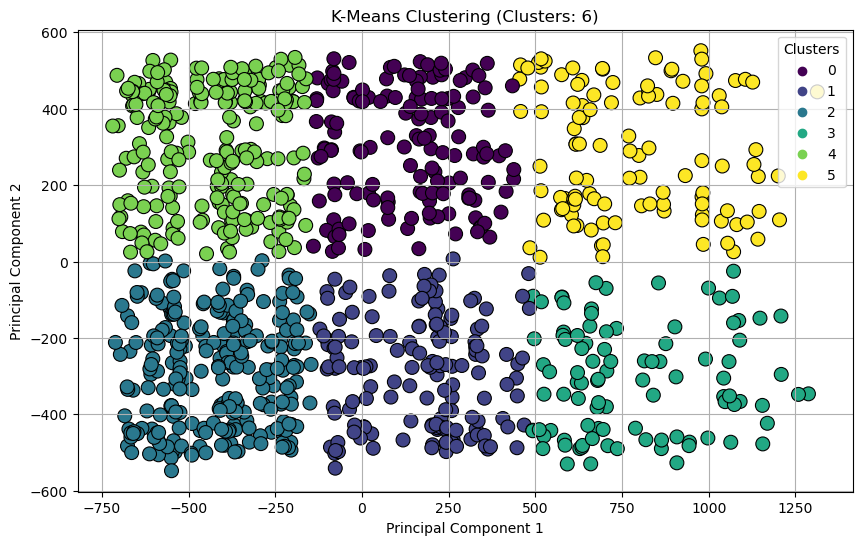

In [13]:
optimal_clusters = 6  
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# K-Means Visualization
kmeans = KMeans(n_clusters=optimal_clusters, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis', s=100, edgecolor='k')
plt.title(f'K-Means Clustering (Clusters: {optimal_clusters})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title="Clusters")
plt.grid(True)
plt.show()